---
title: "Braket Module"
author: 
    - name: Francesco Scala 
    - name: Adapted by Ram Mosco
date: "2024-06-21"
categories: [code]
image: "braket_cover.png"
image-width: "1cm"
image-height: "1cm"
format:
    html:
        code-fold: false
        eval: true
jupyter: blogqa
code-annotations: hover
---

This is a tutorial to get to know the new Tequila's function: braket. 

With this new function you will be able to easily compute:

1. self overlaps
2. overlaps between two different states
3. the expectation value of an operator
4. the transition element of an operator

So, let's import Tequila (and some of its modules) and see how this function works.

In [1]:
#tequila importations
import tequila as tq
from tequila.circuit.gates import H, X, Rx, CX
from tequila.hamiltonian.qubit_hamiltonian import QubitHamiltonian

#extra importations
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Basic usage

## 1. Self overlap

Let's begin from the simplest (and maybe trivial) possible application of the `braket` function: the computation of the self overlap of a quantum state. One can prepare an arbitrary circuit, corresponding to the state $|\psi\rangle$ and then calculate the self overlap $$\langle \psi|\psi\rangle.$$ 

We can prepare for example a Bell state of two qubits:

Note you can also run `tq.draw(bell, backend='qiskit')` for drawing the circuit (optional). It would result in a circuit like the one below 

In [2]:
bell = tq.QCircuit() #<1>
bell += H(0) #<2>
bell += CX(0,1) #<3>


1. creates an empty circuit object with no gates 
2. add a hadamard gate to qubit 0 
3. add a $CNOT$ with control in qubit 1 and target in 1 


![](B1.png){width=30%}


Then, we can simply call the `braket` function passing as unique argument our quantum circuit, this can also be specified as `ket`:

In [3]:
self_overlap_real, self_overlap_im = tq.braket(ket=bell) #<1>

self_overlap = self_overlap_real + 1.0j*self_overlap_im #<2>

1. get the real and the imaginary part of the state 
2. join the save and imaginary part of the overlap. `self_overlap` is not a complex number 

As we have seen the braket function always return two objects, one for the real part and one for the imaginary one. These are `tq.Objecitve` and need to be simulated in order to obtain a numeric value.


Due to the laws of quantum mechanics the overlap of a state with itself, namely the self overlap, must always be equal to 1, namely $$\langle \psi|\psi\rangle=1.$$

In [4]:
self_overlap_value = tq.simulate(self_overlap) #<1>
assert self_overlap_value == 1 #<2>

/opt/anaconda3/envs/BlogQA/lib/python3.9/site-packages/tequila/objective/objective.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  result = onp.asarray(self.transformation(*ev_array), dtype=float)


1. compute the self overlap of the state
2. if the self overlap is not equal to $1$, this should throw an exception 

In this particular case Tequila is aware that the self overlap is always 1, so no circuit needs to be executed. This can be checked by printing the `self_overlap` Objective:

Note that this object consists of further attributes rather than only the mere value 

In [5]:
print(self_overlap) #<1>

Objective with 0 unique expectation values
total measurements = 0
variables          = []
types              = []


1. printing the overlap shows all of its object attributes 

## 2. Overlap between two different states

The second step will be to compute the overlap between different states $$\langle\psi _2|\psi _1\rangle.$$ Even in this case we can exploit the `braket` function.

Let's prepare two orthogonal states. In this case the overlap must be equal to 0:


In [6]:
U0 = X(0) # state |10> #<1>
U1 = H(0)+CX(0,1) # Bell state 1/sqrt(2)*(|00>+|11>) #<2>


1. this circuit will perpare the two-qubit state |10> since we assume two input-qubits in state |0> and a $X$ (NOT) is applied to the first one
2. also here we assume an input of |00> and send it through the circuit that generated the 4 bell-states

Now, we can call the `braket` function passing as arguments our quantum circuits, specifying which will be the `ket` and which the `bra`.
Otherwise the first will be automatically selected as `ket` and second as `bra`:

In [7]:
br_objective_real, br_objective_im = tq.braket(ket=U0, bra=U1) #<1>
br_overlap = br_objective_real + 1.0j*br_objective_im #<2>
br_overlap_value = tq.simulate(br_overlap) #<3>

br_overlap_value #<4>

0.0

1. specify input states for writing them in the braket notation
2. joining real and imaginary part based on the states produced by the circuits `U0` and `U1`
3. simulates the `tq.Objective` object to obtain a numeric values 
4. prints the overlap, this one should be equal to $0$

We can also define a non-orthogonal state with respect to the previous prepared Bell state. This can be obtained for example by preparing a Bell state followed by a rotation around X-axis. 

One can then check that changing the angle value will result in changing the overlap between the two states:

Text(0, 0.5, 'Overlap')

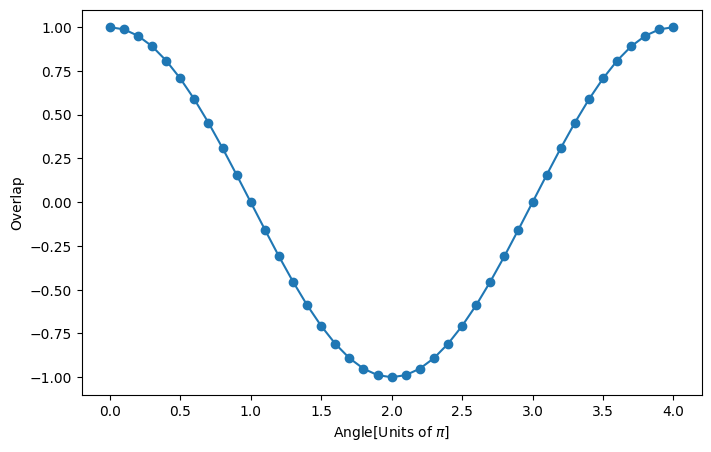

In [8]:
angle = tq.Variable("angle") #<1>
U2 = U1 + Rx(angle*np.pi, 1) #<2>

br_objective_real, br_objective_im = tq.braket(ket=U1, bra=U2) #<3>
br_overlap = br_objective_real + 1.0j*br_objective_im #<4>
S = tq.compile(br_overlap) #<5>

overlaps = []
for value in np.arange(0,4.1, 0.1): #<6>
# set the value of the angle we want to simulate
    variables = {"angle" : value} #<7>
    # let's simulate the Objective
    br_overlap_value = S(variables=variables) #<8>
    overlaps.append(round(br_overlap_value,3)) #<9>

# plotting the trend 
fig = plt.figure(figsize=(8,5)) #<10>

plt.plot(np.arange(0,4.1, 0.1), overlaps, marker = 'o')
plt.xlabel(r'Angle[Units of $\pi$]')
plt.ylabel('Overlap')

1. declare a variable of for a parametrized angle 
2. Bell state followed by a rotation around X-axis
3. fetch once again the real and imaginary components after writing the input states in braket form
4. prepare real and imaginary part for overlap computation
5. translate to backend - compile the state with an arbitrary parametrized angle
6. generates values from the intervall $[0,4.1]$ with steps of $0.1$ for simulating multiple angles
7. associate angle with generated value from range above
8. simulate the `tq.Objective` object ad get the computed overlap
9. append the achieved value to a list of overlaps, since we compute multiple overlaps for multiple angles 
10. display the resulted numerical values of the overlaps as a graph 



The resulting graphic depicts the trend of the overlaps for the given states above and angles within the interval $[0, 4.1]$ with steps of $0.1$ between interval begin and interval end.

## 3. Expectation value of an Hamiltonian

At this stage, we can see how to use the `braket` function to calculate the expectation value of an Hamiltonian $H$ with respect to a given state $|\psi\rangle$: $$\langle\psi|H|\psi\rangle.$$

In [9]:
psi = H(0)+CX(0,1) # Bell state 1/sqrt(2)*(|00>+|11>) #<1>

#Hamiltonian definition
operator = QubitHamiltonian.from_string("-1.0*X(0)X(1)") #<2>

1. as before define the first bell state with the circuit generating the bell-basis and an input of |00>
2. define an hamiltonian - this one is a sequence of Pauli-$X$ matrices acting on the second and the first qubits respectivly and then a scale factor of $-1$


Now, one needs to pass to the `braket` function as `ket` argument our state and as `operator` argument the Hamiltonian.

As already seen before, always keep in mind that the `braket` function returns two Objecitves that need to be compiled afterwards. 

With previous defined state and Hamiltonian we need to obtain an expectation value equal to $-1$.

**Note**: now we utilize the `braket` function for computing an *expectation value* and not an *overlap* between two states as we did before, but since we provide the function this time with an *hamiltonian = hermitian operator* and a state instead of two states, the expectation value will be computed and not the overlap - no special changes needed.

In [10]:
br_exp_value_real, br_exp_value_im = tq.braket(ket=psi, operator=operator) #<1>
br_exp_value_tmp = br_exp_value_real + 1.0j*br_exp_value_im #<2>
br_exp_value = tq.simulate(br_exp_value_tmp) #<3>

br_exp_value #<4>

-0.9999999999999998

1. applying the braket function on the bell-state and the hamiltonian, defining the hamiltonian as an `operator` - important
2. joining real and imaginary part for computation
3. simulate the expectation value 
4. show the expectatino value, should be equal to $1$

Tequila is aware that an `ExpectationValue` is always real, so no circuit needs to be executed for the imaginary part. One can see this by printing `br_exp_value_im`:

In [11]:
print(br_exp_value_im)

Objective with 0 unique expectation values
total measurements = 0
variables          = []
types              = []


## 4. Transition element of an Hamiltonian

As last application, the `braket` function can be used to calculate transition elements of an operator $H$ with respect to two different states $|\alpha\rangle, \ |\beta\rangle$: $$\langle\beta|H|\alpha\rangle.$$

In order to see how things can change, we can proceed similarly to section 2 and vary the angle of a rotation:  

In [12]:
#states definition
alpha = H(0)+CX(0,1) # Bell state 1/sqrt(2)*(|00>+|11>) #<1>
angle = tq.Variable("angle") #<2>
beta = alpha + Rx(angle*np.pi, 1) # Bell state followed by a rotation around X-axis #<3>

#Hamiltonian definition
operator = QubitHamiltonian("-1.0*X(0)X(1)") #<4>

br_trans_real, br_trans_im = tq.braket(ket=alpha, bra=beta, operator=operator) #<5>
br_trans_el = br_trans_real + 1.0j*br_trans_im  #<6>
H_ab = tq.compile(br_trans_el) #<7>

transitions = []    
for value in np.arange(0,4.1, 0.1): #<8>
    variables = {"angle" : value}  #<9>
    br_trans_value = H_ab(variables=variables) #<10>
    transitions.append(round(br_trans_value,3)) #<11>

1. create the bell state the same way as before
2. define a general angle for later computations as in the last example
3. add a rotation after the bell state
4. define the hamiltonian the same way as before
5. apply `braket` function, specify the `ket` and the `bra` as the bell state and the bell state followed by the $X$ rotation respectively and get the real and imaginary part 
6. use the real and imaginary part for creating a complex number 
7. compile this complex number by translating it to the backend
8. use the same interval as a range for angle generation as before and the same step size
9. set the of the angle we want to simulate
10. simulate the `tq.Objective` to get the computed value
11. store these values rounded by 3 digits after the comma into a list of transitions for later plot


Text(0, 0.5, 'Transitions')

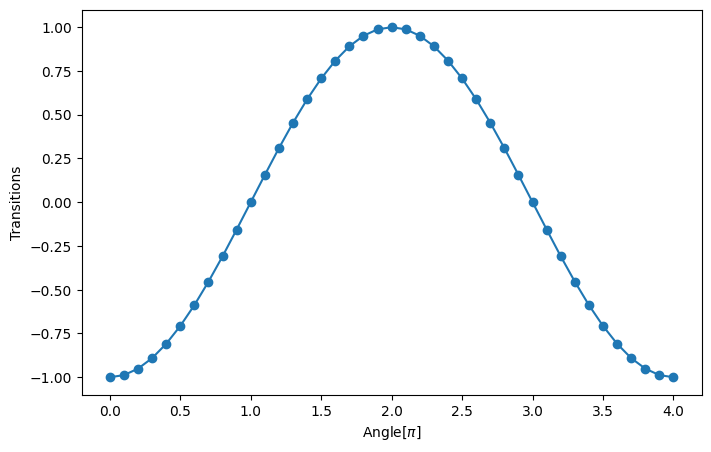

In [13]:
#plotting the trend
fig = plt.figure(figsize=(8,5)) 
plt.plot(np.arange(0,4.1, 0.1), transitions, marker = 'o')
plt.xlabel(r'Angle[$\pi$]')
plt.ylabel('Transitions')

Even in this particular case the imaginary part is 0 (as for an `ExpectationValue`), but in this case this happens because the wave functions are real. The difference can be noticed again by printing `br_trans_im` where in this case there is one circuit to be executed:

In [14]:
print(br_trans_im)

Objective with 1 unique expectation values
total measurements = 1
variables          = [angle]
types              = not compiled


In the end, we can address one small example in which the imaginary part is not 0. 
We have:
$$|\psi_0\rangle=R_x(a)\rvert  0 \rangle = \cos(a/2) \rvert 0 \rangle - i\sin(a/2)\rvert 1\rangle$$
$$|\psi_1\rangle=R_y(b)\rvert  0 \rangle = \cos(b/2) \rvert 0 \rangle + \sin(b/2)\rvert 1\rangle$$ 

and so the imaginary part of the transition amplitude comes down to 
$$\text{Im}(\langle\psi_1|Z|\psi_0\rangle ) = -\sin(a/2)\sin(b/2).$$

In [15]:
#states definition
a = tq.Variable("a") #<1>
b = 1 

U0 = tq.gates.Rx(a*np.pi,0) #<2>
U1 = tq.gates.Ry(b*np.pi,0) #<3>

#Hamiltonian definition
operator = QubitHamiltonian("1.0*Z(0)") #<4>

br_trans_real, br_trans_im = tq.braket(ket=U0, bra=U1, operator=operator) #<5>

H_i = tq.compile(br_trans_im) #  #<6>

transitions = []
for a in np.arange(0,4.1, 0.1): #<7>
    variables = {"a" : a} #<8>
    br_trans_value = H_i(variables=variables) #<9>
    transitions.append(round(br_trans_value,3)) #<10>

1. declare a variable of a general angle $a$
2. declare a rotation around $X$ with the angle $a\pi$
3. rotation around $Y$ axis with a fixed angle of $\pi$
4. hamiltonian with a paulii $Z$ gate on the first qubit
5. specify ket, bra and operator and fetch the imaginary and real part 
6. transalte to backend and get the operator 
7. same range and step size as before
8. set the angle values we want to simulate
9. simulate the `tq.Objective` to get the computed value 
10. store the computed values in a list for plotting

Text(0, 0.5, 'Transitions')

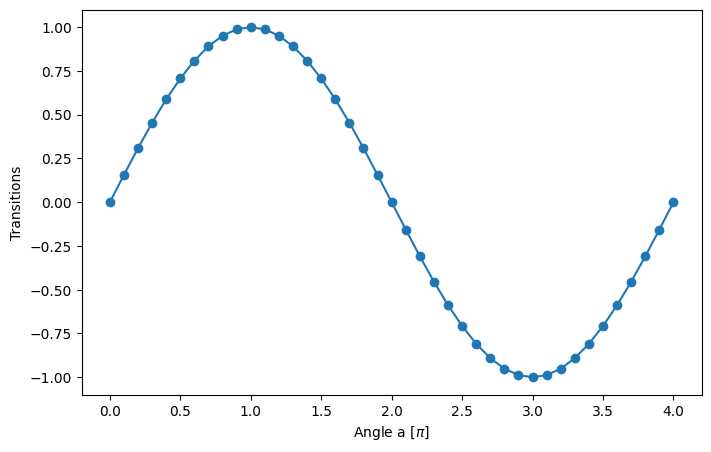

In [16]:
#plotting the trend
fig = plt.figure(figsize=(8,5))
plt.plot(np.arange(0,4.1, 0.1), transitions, marker = 'o')
plt.xlabel(r'Angle a [$\pi$]')
plt.ylabel('Transitions')

# Detailed explanation of internal `braket` structure

Let's give some insight about the underlying structure of `braket`.
This function in general just calls other functions to do all the different tasks one may need.

More in detail, the function acts as follows:

## Self Overlap 
- If only ket is passed, `braket` directly returns the real and imaginary part of the `self-overlap` as `Objective()`. 
- This is required since one may combine the different `braket` modalities and this will require the compilation of an `Objective()`.

## Expectation Value 
- If ket and operator are passed, `braket` returns the `ExpectationValue` of the operator for the given state.

## General Overlap 
- If ket and bra are passed, `braket` returns the overlap between the two states. This is done by calling a new Tequila's function called `make_overlap`. 
Further below this section we describe also how this function works.

## Transition Element
- If ket, bra and operator are passed, `braket` returns the transition element of the operator by calling another new Tequila's function called `make_transition`. Even in this case we provide a description of the internal structure.

# Detailed explanation of the `make_overlap` function 

### `Make_overlap` and `make_transition`

The `make_overlap` function constructs the following circuit that is able to calculate the overlap between two states of $n$ qubits. 

<p align='center'>
<img src="overlap_circuit.png" alt="overlap circ" width="500"/>
</p>

Here, $U_0$ and $U_1$ are two unitaries such that: 

$$U_0 |0\rangle^n=|\psi _ 0 \rangle \quad , \quad U_1 |0\rangle^n=|\psi _ 1 \rangle$$ 

so the circuit prepares the state:

$$ \frac{1}{\sqrt{2}}(|\psi _ 0 \rangle|0\rangle+|\psi _ 1 \rangle|1\rangle) \quad $$

In the end measuring the ancilla in the $2\sigma_+$ base, gives as output:

$$^n\langle 0|U_ 0 ^\dagger U_1 |0\rangle^n=\langle\psi _ 0 |\psi _ 1 \rangle \quad $$

We can check the circuit build by the `braket` function with the code contained in the next cell:

In [17]:
U0 = X(0) # state |10> #<1>
U1 = H(0)+CX(0,1) # Bell state 1/sqrt(2)*(|00>+|11>) #<2>

br_objective_real, br_objective_im = tq.braket(ket=U1, bra=U0) #<3>

# tq.draw(br_objective_real) #<4>


1. assume two qubits in $|00>$ and flip the first qubit to get $|10>$
2. prepare a bell state as before
3. get the real and imaginary parts consistently with the explained notation 
4. optionally draw the resulted circuit, should look like the one below 

![](B2.png){width=70%}

The resulting circuit should look like this 

As we can see that one ancilla qubit has been added to our quantum register to be used as control qubit.
The two circuits have been controlled and applied with the correct structure: the ancilla has a $H$ gate allowing superposition, the $U_0$ is performed when the ancilla is in state $|0\rangle$ and the $U_1$ when the ancilla is in state $|1\rangle$. This circuit will be then measured in the $X$ and $Y$ basis to obtain, respectively, the real and the imaginary part $$(2\sigma_+=X+iY).$$

Regarding the `make_transition` function, this exploits `make_overlap` to calculate multiple contributes of Pauli strings within an Hamiltonian operator. More in detail, suppose we have an Hamiltonian $H$ that can be decomposed as:

$$H = \sum_k c_k P_k$$

where $P_k$ are Pauli strings (tensor product of Pauli operators acting on different qubits). Then, in order to calcuate the transition element, we can compute the single contributions and sum them up:

$$\langle\psi _ 0 | H |\psi _ 1 \rangle = \sum_k c_k \langle\psi _ 0 | P_k |\psi _ 1 \rangle \quad $$

Each of these contributions can be obtained from `make_overlap` by appending to the $U_1$ circuit the one that implements the Pauli string:
$$\langle\psi _ 0 | H |\psi _ 1 \rangle = \sum_k c_k \langle\psi _ 0 | P_k \psi _ 1 \rangle \quad $$



In [18]:
U0 = X(0) # state |10> #<1>
U1 = H(0)+CX(0,1) # Bell state 1/sqrt(2)*(|00>+|11>) #<2>

#Hamiltonian definition
operator = QubitHamiltonian("-1.0*X(0)X(1)+0.5*Z(0)") #<3>

br_trans_real, br_trans_im = tq.braket(ket=U1, bra=U0, operator=operator)#<4>

# tq.draw(br_trans_real) #<5>

1. prepare state for $U_0$ the same way as before
2. prepare bell state
3. decalre hermitian operator consisting of a $Z$ and two $X$ paulis
4. use the `braket`function to fetch imaginary and real consistently with the explained notation as before
5. optional: draw the circuits, thuy should look like the two circuits below 

![](B3.png){width=70%}

![](B4.png){width=70%}


The resulting circuits should look like this 

We can see that both `br_trans_real` and ` br_trans_im` contain in this case 2 circuits with the same gates in the first part of the circuit, but different gates corresponding to the Pauli operators in the Pauli strings.

These two functions were designed according to "N. H. Stair *et al.* - A Multireference Quantum Krylov Algorithm for Strongly Correlated Electrons" - [arXiv:1911.05163v1](https://arxiv.org/abs/1911.05163), [published paper](https://pubs.acs.org/doi/10.1021/acs.jctc.9b01125).

**ATTENTION**: In the attached ArXiv paper an $X$ gate before the control of $U_\alpha$ in Figure 2 is missing. This has been fixed in the published paper.